In [16]:
import gymnasium as gym
import collections
import random
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [9]:
#Hyperparameters
learning_rate = 0.0005
gamma         = 0.98
buffer_limit  = 50000
batch_size    = 128

soft_update = False
if soft_update:
    tau = 0.005
minimum_n_epi = 300 # minimum number of episodes to train

In [10]:
class ReplayBuffer():
    def __init__(self):
        #FIFO : sampling을 순서대로 뽑는 의미가 아니라 오래된게 먼저 버려진다는 의미
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        # 실제 sampling은 random sampling
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a]) # s랑 비슷한 모양으로 만들어주기 위해
            r_lst.append([r]) 
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask]) 
        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst),\
                torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float),\
                torch.tensor(done_mask_lst)
    
    def size(self):
        return len(self.buffer)
            

In [11]:
class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(4,128) #the shape of observation is (4,) 
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128,2) # the action space is 2, shape of action is (1,)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def sample_action(self, obs, epsilon):
        # obs : state
        out = self.forward(obs)
        # epsilon greedy
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else:
            return out.argmax().item() # select a_t = argmax_a Q(s_t,a) # item() : tensor에서 값만 뽑아내기(env.step()의 input)

    

In [12]:
def train(q, q_target, memory, optimizer):
    loss_lst = []
    # 얘를 100으로 정해주지 않고 episode가 끝날 때마다 update
    for i in range(100):
        s, a, r, s_prime, done_mask = memory.sample(batch_size)
        # s : (batch_size, 4)

        q_out = q(s) # (batch_size, 2)
        
        q_a = q_out.gather(1,a) #a를 index로 사용해서 q_out에서 해당하는 action의 q값만 뽑아옴 -> q(s,a)
        with torch.no_grad():
            max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1) # (batch_size, 1) #.max()[0] : value, [1] : index
        target = r + gamma * max_q_prime * done_mask# (batch_size, 1) #.max()[0] : value, [1] : index
        loss = F.smooth_l1_loss(q_a, target)
        loss_lst.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss_lst
        

In [13]:
from tqdm import tqdm

In [14]:
env = gym.make('CartPole-v1')
q = Qnet()
q_target = Qnet()
q_target.load_state_dict(q.state_dict())
memory = ReplayBuffer()

print_interval = 20
score = 0.0  
optimizer = optim.Adam(q.parameters(), lr=learning_rate)

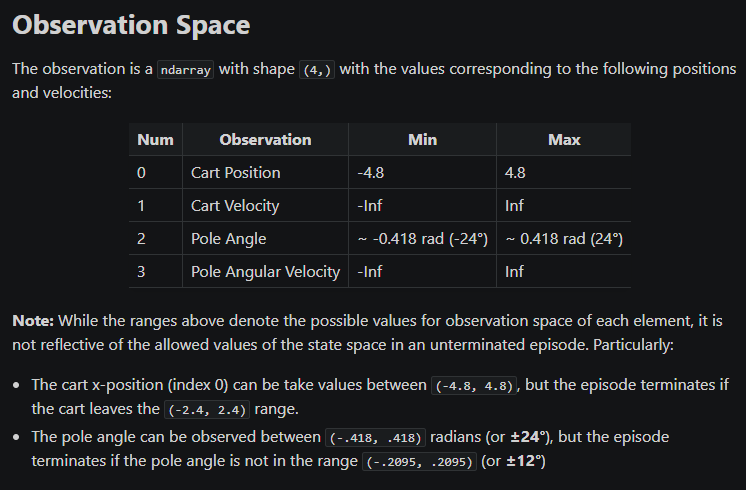

In [17]:
ll = []
for n_epi in tqdm(range(10000)):
    epsilon = max(0.01, 0.08 - 0.01*(n_epi/200)) #Linear annealing from 8% to 1%
    s, _ = env.reset()
    done = False


    for t in count():
        # select a_t = argmax_a Q(s_t,a)
        a = q.sample_action(torch.from_numpy(s).float(), epsilon)
        # https://gymnasium.farama.org/api/env/#gymnasium.Env.step
        s_prime, r, done, truncated, info = env.step(a) 
        
        # to prevent one episode running too long
        if (t > 500) or done:
            done_mask = 0.0
        else:
            done_mask = 1.0
        
        memory.put((s, a, r/100.0, s_prime, done_mask))
        s = s_prime

        score += r
        if done_mask == 0.:
            break
    
    if memory.size() > minimum_n_epi:
        lst = train(q, q_target, memory, optimizer) #train함수 안에서 loop를 돌면 하나의 에피소드 안에서 여러번 train이 되는것
        # option2. 에피소드 하나당 train 한번만 하는것 -> for을 밖으로 빼주면 좀더 exploration하는 학습 방법이 될듯 -> 학습 초기에는 안좋지만 나중에는 수렴성이 있어서 좋을듯
        ll.append(lst)

    # q_target을 q로 업데이트
    if n_epi%print_interval==0 and n_epi!=0:
        if soft_update : 
            q_target_sd = q_target.state_dict()
            q_sd = q.state_dict()
            for key in target_sd:
                q_target_sd[key] = q_sd[key]*tau + target_sd[key]*(1 - tau)
            q_target.load_state_dict(q_target_sd)
        else :
            q_target.load_state_dict(q.state_dict())

        #score/print_interval : avg score of print_interval episodes with updated q
        print("# of episode :{}, avg score : {:.1f}, buffer size : {}, epsilon : {:.1f}%".format(
                                                            n_epi, score/print_interval, memory.size(), epsilon*100))
        
        score = 0.0

env.close()


  0%|                                                                                                                                                                 | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_18181/324566924.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525495809/work/torch/csrc/utils/tensor_new.cpp:230.)
  return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst),\
  0%|▍                                                                                                                                                      | 33/10000 [00:00<00:43, 230.74it/s]

# of episode :20, avg score : 9.8, buffer size : 197, epsilon : 7.9%
# of episode :40, avg score : 9.9, buffer size : 395, epsilon : 7.8%


  1%|▊                                                                                                                                                       | 57/10000 [00:02<07:36, 21.80it/s]

# of episode :60, avg score : 10.0, buffer size : 595, epsilon : 7.7%


  1%|█▏                                                                                                                                                      | 80/10000 [00:04<11:08, 14.83it/s]

# of episode :80, avg score : 10.3, buffer size : 802, epsilon : 7.6%


  1%|█▌                                                                                                                                                     | 101/10000 [00:06<16:08, 10.22it/s]

# of episode :100, avg score : 20.1, buffer size : 1203, epsilon : 7.5%


  1%|█▊                                                                                                                                                     | 121/10000 [00:08<16:14, 10.14it/s]

# of episode :120, avg score : 40.6, buffer size : 2016, epsilon : 7.4%


  1%|██▏                                                                                                                                                    | 141/10000 [00:10<17:42,  9.28it/s]

# of episode :140, avg score : 78.8, buffer size : 3593, epsilon : 7.3%


  2%|██▍                                                                                                                                                    | 162/10000 [00:12<19:33,  8.38it/s]

# of episode :160, avg score : 191.4, buffer size : 7421, epsilon : 7.2%


  2%|██▋                                                                                                                                                    | 182/10000 [00:15<19:57,  8.20it/s]

# of episode :180, avg score : 286.0, buffer size : 13141, epsilon : 7.1%


  2%|███                                                                                                                                                    | 202/10000 [00:18<22:51,  7.14it/s]

# of episode :200, avg score : 424.3, buffer size : 21627, epsilon : 7.0%


  2%|███▎                                                                                                                                                   | 222/10000 [00:20<23:03,  7.07it/s]

# of episode :220, avg score : 502.0, buffer size : 31667, epsilon : 6.9%


  2%|███▋                                                                                                                                                   | 242/10000 [00:23<20:24,  7.97it/s]

# of episode :240, avg score : 419.1, buffer size : 40049, epsilon : 6.8%


  3%|███▉                                                                                                                                                   | 262/10000 [00:26<21:34,  7.52it/s]

# of episode :260, avg score : 391.3, buffer size : 47875, epsilon : 6.7%


  3%|████▎                                                                                                                                                  | 282/10000 [00:29<23:10,  6.99it/s]

# of episode :280, avg score : 390.9, buffer size : 50000, epsilon : 6.6%


  3%|████▌                                                                                                                                                  | 302/10000 [00:31<20:28,  7.90it/s]

# of episode :300, avg score : 219.7, buffer size : 50000, epsilon : 6.5%


  3%|████▊                                                                                                                                                  | 322/10000 [00:34<20:47,  7.76it/s]

# of episode :320, avg score : 162.1, buffer size : 50000, epsilon : 6.4%


  3%|█████▏                                                                                                                                                 | 342/10000 [00:37<20:52,  7.71it/s]

# of episode :340, avg score : 153.7, buffer size : 50000, epsilon : 6.3%


  4%|█████▍                                                                                                                                                 | 362/10000 [00:39<21:45,  7.38it/s]

# of episode :360, avg score : 140.2, buffer size : 50000, epsilon : 6.2%


  4%|█████▊                                                                                                                                                 | 382/10000 [00:42<20:25,  7.85it/s]

# of episode :380, avg score : 162.1, buffer size : 50000, epsilon : 6.1%


  4%|██████                                                                                                                                                 | 402/10000 [00:44<20:24,  7.84it/s]

# of episode :400, avg score : 174.8, buffer size : 50000, epsilon : 6.0%


  4%|██████▎                                                                                                                                                | 422/10000 [00:47<20:10,  7.91it/s]

# of episode :420, avg score : 162.8, buffer size : 50000, epsilon : 5.9%


  4%|██████▋                                                                                                                                                | 442/10000 [00:50<21:19,  7.47it/s]

# of episode :440, avg score : 170.6, buffer size : 50000, epsilon : 5.8%


  5%|██████▉                                                                                                                                                | 462/10000 [00:52<23:14,  6.84it/s]

# of episode :460, avg score : 237.7, buffer size : 50000, epsilon : 5.7%


  5%|███████▎                                                                                                                                               | 482/10000 [00:55<21:05,  7.52it/s]

# of episode :480, avg score : 173.6, buffer size : 50000, epsilon : 5.6%


  5%|███████▌                                                                                                                                               | 502/10000 [00:58<22:45,  6.95it/s]

# of episode :500, avg score : 143.5, buffer size : 50000, epsilon : 5.5%


  5%|███████▉                                                                                                                                               | 522/10000 [01:01<21:05,  7.49it/s]

# of episode :520, avg score : 119.8, buffer size : 50000, epsilon : 5.4%


  5%|████████▏                                                                                                                                              | 542/10000 [01:04<20:36,  7.65it/s]

# of episode :540, avg score : 103.3, buffer size : 50000, epsilon : 5.3%


  6%|████████▍                                                                                                                                              | 562/10000 [01:07<22:49,  6.89it/s]

# of episode :560, avg score : 132.2, buffer size : 50000, epsilon : 5.2%


  6%|████████▊                                                                                                                                              | 582/10000 [01:10<22:58,  6.83it/s]

# of episode :580, avg score : 201.0, buffer size : 50000, epsilon : 5.1%


  6%|█████████                                                                                                                                              | 602/10000 [01:13<21:31,  7.28it/s]

# of episode :600, avg score : 317.1, buffer size : 50000, epsilon : 5.0%


  6%|█████████▍                                                                                                                                             | 622/10000 [01:15<22:29,  6.95it/s]

# of episode :620, avg score : 177.1, buffer size : 50000, epsilon : 4.9%


  6%|█████████▋                                                                                                                                             | 642/10000 [01:18<23:18,  6.69it/s]

# of episode :640, avg score : 226.7, buffer size : 50000, epsilon : 4.8%


  7%|█████████▉                                                                                                                                             | 662/10000 [01:22<24:59,  6.23it/s]

# of episode :660, avg score : 164.2, buffer size : 50000, epsilon : 4.7%


  7%|██████████▎                                                                                                                                            | 682/10000 [01:25<25:20,  6.13it/s]

# of episode :680, avg score : 196.0, buffer size : 50000, epsilon : 4.6%


  7%|██████████▌                                                                                                                                            | 702/10000 [01:28<24:05,  6.43it/s]

# of episode :700, avg score : 199.8, buffer size : 50000, epsilon : 4.5%


  7%|██████████▉                                                                                                                                            | 722/10000 [01:31<25:32,  6.05it/s]

# of episode :720, avg score : 149.6, buffer size : 50000, epsilon : 4.4%


  7%|███████████▏                                                                                                                                           | 742/10000 [01:34<22:59,  6.71it/s]

# of episode :740, avg score : 112.2, buffer size : 50000, epsilon : 4.3%


  8%|███████████▌                                                                                                                                           | 762/10000 [01:37<23:19,  6.60it/s]

# of episode :760, avg score : 128.6, buffer size : 50000, epsilon : 4.2%


  8%|███████████▊                                                                                                                                           | 782/10000 [01:40<23:11,  6.62it/s]

# of episode :780, avg score : 104.5, buffer size : 50000, epsilon : 4.1%


  8%|████████████                                                                                                                                           | 802/10000 [01:44<25:38,  5.98it/s]

# of episode :800, avg score : 151.9, buffer size : 50000, epsilon : 4.0%


  8%|████████████▍                                                                                                                                          | 822/10000 [01:47<24:03,  6.36it/s]

# of episode :820, avg score : 188.2, buffer size : 50000, epsilon : 3.9%


  8%|████████████▋                                                                                                                                          | 842/10000 [01:50<24:45,  6.17it/s]

# of episode :840, avg score : 179.0, buffer size : 50000, epsilon : 3.8%


  9%|█████████████                                                                                                                                          | 862/10000 [01:53<25:21,  6.01it/s]

# of episode :860, avg score : 243.8, buffer size : 50000, epsilon : 3.7%


  9%|█████████████▎                                                                                                                                         | 882/10000 [01:57<25:02,  6.07it/s]

# of episode :880, avg score : 226.2, buffer size : 50000, epsilon : 3.6%


  9%|█████████████▌                                                                                                                                         | 902/10000 [02:00<26:24,  5.74it/s]

# of episode :900, avg score : 190.4, buffer size : 50000, epsilon : 3.5%


  9%|█████████████▉                                                                                                                                         | 922/10000 [02:03<25:49,  5.86it/s]

# of episode :920, avg score : 157.4, buffer size : 50000, epsilon : 3.4%


  9%|██████████████▏                                                                                                                                        | 942/10000 [02:07<26:50,  5.62it/s]

# of episode :940, avg score : 145.9, buffer size : 50000, epsilon : 3.3%


 10%|██████████████▌                                                                                                                                        | 962/10000 [02:10<25:07,  6.00it/s]

# of episode :960, avg score : 132.4, buffer size : 50000, epsilon : 3.2%


 10%|██████████████▊                                                                                                                                        | 982/10000 [02:13<24:58,  6.02it/s]

# of episode :980, avg score : 115.2, buffer size : 50000, epsilon : 3.1%


 10%|███████████████                                                                                                                                       | 1002/10000 [02:17<24:33,  6.11it/s]

# of episode :1000, avg score : 168.3, buffer size : 50000, epsilon : 3.0%


 10%|███████████████▎                                                                                                                                      | 1022/10000 [02:20<24:50,  6.02it/s]

# of episode :1020, avg score : 308.1, buffer size : 50000, epsilon : 2.9%


 10%|███████████████▋                                                                                                                                      | 1042/10000 [02:24<28:07,  5.31it/s]

# of episode :1040, avg score : 441.0, buffer size : 50000, epsilon : 2.8%


 11%|███████████████▉                                                                                                                                      | 1061/10000 [02:27<28:53,  5.16it/s]

# of episode :1060, avg score : 464.2, buffer size : 50000, epsilon : 2.7%


 11%|████████████████▏                                                                                                                                     | 1082/10000 [02:31<27:40,  5.37it/s]

# of episode :1080, avg score : 502.0, buffer size : 50000, epsilon : 2.6%


 11%|████████████████▌                                                                                                                                     | 1101/10000 [02:35<30:56,  4.79it/s]

# of episode :1100, avg score : 483.1, buffer size : 50000, epsilon : 2.5%


 11%|████████████████▊                                                                                                                                     | 1122/10000 [02:39<28:20,  5.22it/s]

# of episode :1120, avg score : 447.8, buffer size : 50000, epsilon : 2.4%


 11%|█████████████████▏                                                                                                                                    | 1142/10000 [02:43<27:38,  5.34it/s]

# of episode :1140, avg score : 463.4, buffer size : 50000, epsilon : 2.3%


 12%|█████████████████▍                                                                                                                                    | 1162/10000 [02:47<27:47,  5.30it/s]

# of episode :1160, avg score : 481.7, buffer size : 50000, epsilon : 2.2%


 12%|█████████████████▋                                                                                                                                    | 1182/10000 [02:51<28:04,  5.24it/s]

# of episode :1180, avg score : 462.2, buffer size : 50000, epsilon : 2.1%


 12%|██████████████████                                                                                                                                    | 1201/10000 [02:54<26:50,  5.46it/s]

# of episode :1200, avg score : 481.1, buffer size : 50000, epsilon : 2.0%


 12%|██████████████████▎                                                                                                                                   | 1221/10000 [02:58<30:39,  4.77it/s]

# of episode :1220, avg score : 484.4, buffer size : 50000, epsilon : 1.9%


 12%|██████████████████▋                                                                                                                                   | 1242/10000 [03:02<27:36,  5.29it/s]

# of episode :1240, avg score : 484.0, buffer size : 50000, epsilon : 1.8%


 13%|██████████████████▉                                                                                                                                   | 1262/10000 [03:06<27:30,  5.30it/s]

# of episode :1260, avg score : 452.6, buffer size : 50000, epsilon : 1.7%


 13%|███████████████████▏                                                                                                                                  | 1281/10000 [03:10<27:29,  5.29it/s]

# of episode :1280, avg score : 486.9, buffer size : 50000, epsilon : 1.6%


 13%|███████████████████▌                                                                                                                                  | 1302/10000 [03:14<26:32,  5.46it/s]

# of episode :1300, avg score : 460.1, buffer size : 50000, epsilon : 1.5%


 13%|███████████████████▊                                                                                                                                  | 1322/10000 [03:18<25:07,  5.76it/s]

# of episode :1320, avg score : 236.8, buffer size : 50000, epsilon : 1.4%


 13%|████████████████████▏                                                                                                                                 | 1342/10000 [03:21<26:34,  5.43it/s]

# of episode :1340, avg score : 121.0, buffer size : 50000, epsilon : 1.3%


 14%|████████████████████▍                                                                                                                                 | 1362/10000 [03:25<27:03,  5.32it/s]

# of episode :1360, avg score : 97.2, buffer size : 50000, epsilon : 1.2%


 14%|████████████████████▋                                                                                                                                 | 1382/10000 [03:29<25:43,  5.58it/s]

# of episode :1380, avg score : 166.2, buffer size : 50000, epsilon : 1.1%


 14%|█████████████████████                                                                                                                                 | 1402/10000 [03:33<24:49,  5.77it/s]

# of episode :1400, avg score : 138.1, buffer size : 50000, epsilon : 1.0%


 14%|█████████████████████▎                                                                                                                                | 1422/10000 [03:36<25:26,  5.62it/s]

# of episode :1420, avg score : 138.8, buffer size : 50000, epsilon : 1.0%


 14%|█████████████████████▋                                                                                                                                | 1442/10000 [03:40<25:56,  5.50it/s]

# of episode :1440, avg score : 106.3, buffer size : 50000, epsilon : 1.0%


 15%|█████████████████████▉                                                                                                                                | 1462/10000 [03:43<24:31,  5.80it/s]

# of episode :1460, avg score : 182.8, buffer size : 50000, epsilon : 1.0%


 15%|██████████████████████▏                                                                                                                               | 1482/10000 [03:47<25:31,  5.56it/s]

# of episode :1480, avg score : 197.3, buffer size : 50000, epsilon : 1.0%


 15%|██████████████████████▌                                                                                                                               | 1501/10000 [03:51<26:34,  5.33it/s]

# of episode :1500, avg score : 227.6, buffer size : 50000, epsilon : 1.0%


 15%|██████████████████████▊                                                                                                                               | 1522/10000 [03:55<28:47,  4.91it/s]

# of episode :1520, avg score : 359.2, buffer size : 50000, epsilon : 1.0%


 15%|███████████████████████▏                                                                                                                              | 1542/10000 [03:59<27:09,  5.19it/s]

# of episode :1540, avg score : 351.3, buffer size : 50000, epsilon : 1.0%


 16%|███████████████████████▍                                                                                                                              | 1561/10000 [04:02<26:50,  5.24it/s]

# of episode :1560, avg score : 416.7, buffer size : 50000, epsilon : 1.0%


 16%|███████████████████████▋                                                                                                                              | 1582/10000 [04:06<25:06,  5.59it/s]

# of episode :1580, avg score : 270.4, buffer size : 50000, epsilon : 1.0%


 16%|████████████████████████                                                                                                                              | 1601/10000 [04:10<27:21,  5.12it/s]

# of episode :1600, avg score : 248.4, buffer size : 50000, epsilon : 1.0%


 16%|████████████████████████▎                                                                                                                             | 1621/10000 [04:14<26:18,  5.31it/s]

# of episode :1620, avg score : 286.9, buffer size : 50000, epsilon : 1.0%


 16%|████████████████████████▋                                                                                                                             | 1642/10000 [04:17<25:49,  5.39it/s]

# of episode :1640, avg score : 265.1, buffer size : 50000, epsilon : 1.0%


 17%|████████████████████████▉                                                                                                                             | 1661/10000 [04:21<26:44,  5.20it/s]

# of episode :1660, avg score : 376.1, buffer size : 50000, epsilon : 1.0%


 17%|█████████████████████████▏                                                                                                                            | 1682/10000 [04:25<26:45,  5.18it/s]

# of episode :1680, avg score : 312.6, buffer size : 50000, epsilon : 1.0%


 17%|█████████████████████████▌                                                                                                                            | 1701/10000 [04:29<25:49,  5.36it/s]

# of episode :1700, avg score : 245.0, buffer size : 50000, epsilon : 1.0%


 17%|█████████████████████████▊                                                                                                                            | 1721/10000 [04:32<24:23,  5.66it/s]

# of episode :1720, avg score : 295.6, buffer size : 50000, epsilon : 1.0%


 17%|██████████████████████████▏                                                                                                                           | 1742/10000 [04:36<25:51,  5.32it/s]

# of episode :1740, avg score : 184.4, buffer size : 50000, epsilon : 1.0%


 18%|██████████████████████████▍                                                                                                                           | 1762/10000 [04:40<25:29,  5.39it/s]

# of episode :1760, avg score : 222.1, buffer size : 50000, epsilon : 1.0%


 18%|██████████████████████████▋                                                                                                                           | 1782/10000 [04:44<25:19,  5.41it/s]

# of episode :1780, avg score : 265.7, buffer size : 50000, epsilon : 1.0%


 18%|███████████████████████████                                                                                                                           | 1802/10000 [04:48<25:25,  5.37it/s]

# of episode :1800, avg score : 413.1, buffer size : 50000, epsilon : 1.0%


 18%|███████████████████████████▎                                                                                                                          | 1821/10000 [04:51<23:31,  5.79it/s]

# of episode :1820, avg score : 286.9, buffer size : 50000, epsilon : 1.0%


 18%|███████████████████████████▋                                                                                                                          | 1842/10000 [04:55<25:15,  5.38it/s]

# of episode :1840, avg score : 267.1, buffer size : 50000, epsilon : 1.0%


 19%|███████████████████████████▉                                                                                                                          | 1862/10000 [04:59<25:49,  5.25it/s]

# of episode :1860, avg score : 449.8, buffer size : 50000, epsilon : 1.0%


 19%|████████████████████████████▏                                                                                                                         | 1882/10000 [05:03<25:46,  5.25it/s]

# of episode :1880, avg score : 258.2, buffer size : 50000, epsilon : 1.0%


 19%|████████████████████████████▌                                                                                                                         | 1901/10000 [05:07<29:17,  4.61it/s]

# of episode :1900, avg score : 434.4, buffer size : 50000, epsilon : 1.0%


 19%|████████████████████████████▊                                                                                                                         | 1921/10000 [05:11<27:32,  4.89it/s]

# of episode :1920, avg score : 328.6, buffer size : 50000, epsilon : 1.0%


 19%|█████████████████████████████▏                                                                                                                        | 1942/10000 [05:15<25:16,  5.31it/s]

# of episode :1940, avg score : 303.1, buffer size : 50000, epsilon : 1.0%


 20%|█████████████████████████████▍                                                                                                                        | 1961/10000 [05:19<27:09,  4.93it/s]

# of episode :1960, avg score : 428.7, buffer size : 50000, epsilon : 1.0%


 20%|█████████████████████████████▋                                                                                                                        | 1982/10000 [05:23<25:12,  5.30it/s]

# of episode :1980, avg score : 478.5, buffer size : 50000, epsilon : 1.0%


 20%|██████████████████████████████                                                                                                                        | 2002/10000 [05:27<26:02,  5.12it/s]

# of episode :2000, avg score : 486.6, buffer size : 50000, epsilon : 1.0%


 20%|██████████████████████████████▎                                                                                                                       | 2022/10000 [05:31<25:42,  5.17it/s]

# of episode :2020, avg score : 438.8, buffer size : 50000, epsilon : 1.0%


 20%|██████████████████████████████▌                                                                                                                       | 2041/10000 [05:35<27:54,  4.75it/s]

# of episode :2040, avg score : 431.6, buffer size : 50000, epsilon : 1.0%


 21%|██████████████████████████████▉                                                                                                                       | 2061/10000 [05:39<27:42,  4.78it/s]

# of episode :2060, avg score : 403.4, buffer size : 50000, epsilon : 1.0%


 21%|███████████████████████████████▏                                                                                                                      | 2082/10000 [05:43<25:54,  5.09it/s]

# of episode :2080, avg score : 304.2, buffer size : 50000, epsilon : 1.0%


 21%|███████████████████████████████▍                                                                                                                      | 2098/10000 [05:46<21:45,  6.05it/s]


KeyboardInterrupt: 